Load modules

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import datetime
from pathlib import Path
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

#settings
plt.rc('font', size=14) 

Load data

In [ ]:
path = Path(r'/Users/sr2/OneDrive - University College London/PhD/Research/'
        'Missions/SWARM/Non-Flight Data/Analysis/Apr-22/data/processing/remove_outliers/')

filename = str(path) + '/2017_eq-sol_outliers.csv'
df = pd.read_csv(filename)

Final clean / sanity check

In [ ]:
#Check time
df = df.sort_values(by=['Timestamp'], ascending = True)

In [ ]:
abc = df.pop('abc')
b_ind = df.pop('b_ind')
time = df.pop('Timestamp')

df=df.dropna()

#Set cadadence
df = df.iloc[::]
df.shape

(1967956, 21)

Split and normalise the data

In [ ]:
#split
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

print ('\n'.join([
    f'Train set size: {len(train_df)}',
    f'Val set size: {len(val_df)}',
    f'Test set size: {len(test_df)}',
    ]))

num_features = df.shape[1]


train_mean = train_df.mean()
train_std = train_df.std()

#Must always use train_mean & train_std so model cannot see any of these vals
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


Train set size: 1377569
Val set size: 393591
Test set size: 196796


Visualise the distribution

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(15, 5), dpi=50)
ax = sns.boxplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Select feature(s) to forecast

In [2]:
feat_to_fore = 'Ne'

Data windowing

In [3]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

NameError: name 'train_df' is not defined

In [8]:
#shift = how many values into the future

OUT = 540
eg_plot = WindowGenerator(input_width=180, label_width=OUT, shift=OUT,
                     label_columns=[feat_to_fore])
eg_plot

Total window size: 720
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
Label indices: [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 2

Split the data into a window of inputs (n) and labels (y)

In [9]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]

  labels = tf.stack([labels[:, :, self.column_indices[name]] 
      for name in self.label_columns],axis=-1)

  #Force update the shape of the tensor
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

#add to class
WindowGenerator.split_window = split_window

Create an example window and plot

All shapes are: ("batch" size, time (input width), # features)
Window shape: (4, 720, 21)
Inputs shape: (4, 180, 21)
Labels shape: (4, 540, 1)


TypeError: 'float' object is not subscriptable

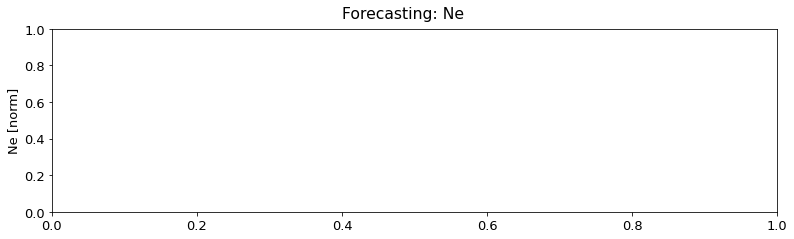

In [11]:
# Stack three slices, the length of the total window.
end_index = eg_plot.total_window_size

#1000:1000 cannot exceed df.shape[0] aka the row length
example_window = tf.stack([np.array(train_df[:end_index]),
                           np.array(train_df[1000:1000+end_index]),
                           #np.array(train_df[100:1700+end_index]),
                           np.array(train_df[900:900+end_index]),
                           np.array(train_df[700:700+end_index])
                           ])

example_inputs, example_labels = eg_plot.split_window(example_window)

print('All shapes are: ("batch" size, time (input width), # features)')
print ('\n'.join([
    f'Window shape: {example_window.shape}',
    f'Inputs shape: {example_inputs.shape}',
    f'Labels shape: {example_labels.shape}',
    ]))

eg_plot.example = example_inputs, example_labels

def plot_example()

def plot(self, model=None, plot_col=feat_to_fore , max_subplots=6, cad=0.06):
   
  inputs, labels = self.example

  #inputs = (inputs * train_std) + train_mean
  #labels = (labels * train_std) + train_mean

  plt.figure(figsize=(13, 15.5))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    #plt.title("Forecasting {}")
    plt.suptitle(f'Forecasting: {feat_to_fore}', y = 0.9, va='top')
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [norm]')
    plt.plot(self.input_indices*cad[::6], inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    #label_col_index = plot_col_index


    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
      #print(label_col_index)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    #print(label_col_index)

    #label_col_index = plot_col_index
    
    plt.rc('font', size=13) 
    plt.scatter(self.label_indices*cad, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      #predictions = (predictions * train_std) + train_mean
      plt.rc('font', size=13) 
      plt.scatter(self.label_indices*cad, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

      #plt.yscale('log')

    if n == 0:
      plt.legend()

  plt.xlabel('Minutes')

WindowGenerator.plot = plot
eg_plot.plot()


Convert the data into a tensorflow time series

In [ ]:
def make_dataset(self, data, batch_size=32):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=batch_size,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
'''
#inspect the elements in the new dataset format
eg_plot.test.element_spec

for example_inputs, example_labels in eg_plot.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')'''

Create a window for modelling and one for plotting

In [ ]:
#shift = how far into the future

OUT_STEPS = 540
plot_window = WindowGenerator(
    input_width=180, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=[feat_to_fore])

run_window = WindowGenerator(
    input_width=180, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=[feat_to_fore])


run the model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

MAX_EPOCHS = 12

def compile_and_fit(model, window, patience=1):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(
                loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  print(model.summary())

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

'''
lstm_model = Sequential([
    LSTM(16, return_sequences=True),
    #LSTM(16, return_sequences=True),
    #LSTM(8, return_sequences=True),

    #Dropout(rate = .3),
    Dense(units=1)
  
])'''

lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])



#print('Input shape:', run_window.example[0].shape)
#print('Output shape:', lstm_model(run_window.example[0]).shape)

lstm_model(run_window.example[0]).shape
print('Input shape:', run_window.example[0].shape)

history = compile_and_fit(lstm_model, run_window)
#IPython.display.clear_output()

In [ ]:
plot_window.plot(lstm_model)

In [ ]:
per = history.history
loss = per['loss']
mae = per['mean_absolute_error']
vloss = per['val_loss']
vmae = per['val_mean_absolute_error']

x = np.arange(len(loss))
plt.title(f"Forecasting {feat_to_fore}", fontsize=14)
sns.lineplot(x=x, y=loss, label="loss")
sns.lineplot(x=x, y=vloss, label = "val loss")

plt.xlabel('epoch')
plt.ylabel('loss')


In [ ]:
x = np.arange(len(loss))
sns.lineplot(x=x, y=mae, label="mae")
sns.lineplot(x=x, y=vmae, label ="vmae")

plt.title(f"Forecasting {feat_to_fore}", fontsize=14)
plt.xlabel('epoch')
plt.ylabel('mean sqaure error')

In [ ]:
import shap
#explainer = shap.DeepExplainer(lstm_model, X_train)

mod_in = lstm_model.layers[0].input
mod_out = lstm_model.layers[-1].output
print(mod_out)

X_train = np.array(run_window.train)
print(X_train)
#explainer = shap.DeepExplainer((mod_in, mod_out), X_train)

# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
#shap_values = explainer.shap_values(X_test)
# init the JS visualization code
#shap.initjs()
#shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)